# G-Wishart Inference

## 1. Static Inference

In [1]:
import numpy as np
import scipy as sp
from sklearn.covariance import GraphLasso
from sklearn.datasets import make_spd_matrix, make_sparse_spd_matrix
from sklearn.linear_model import LassoLars

In [15]:
tol = 1e-8

n_dim = 5
n_samples = 100

np.random.seed(0)
K = make_sparse_spd_matrix(n_dim, alpha=0.75)
Sigma = sp.linalg.pinvh(K)

X = np.random.multivariate_normal(np.zeros(n_dim), Sigma, size=n_samples)

In [40]:
from regain.bayesian import gwishart_inference; reload(gwishart_inference)
from regain.bayesian.gwishart_inference import *
n_samples, n_dim = X.shape
alphas = np.logspace(-2, 0, 20)

# get a series of Markov blankets for vaiours alphas
mdl = GraphLasso(verbose=False)
precisions = [
    mdl.set_params(alpha=a).fit(X).precision_
    for a in alphas]
mblankets = markov_blankets(precisions, tol=tol, unique=1)

In [41]:
normalized_scores = score_blankets(mblankets, X=X, alphas=[0.01, 0.5, 1])

graphs = get_graphs(mblankets, normalized_scores, n_dim=n_dim,
                    n_resampling=200)

nonzeros_all = [np.triu(g, 1) + np.eye(n_dim, dtype=bool) for g in graphs]

# Roverato'02: convert from HIW to G-Wishart (delta + |V| - 1)
d0 = 3 + n_dim - 1
S0 = np.eye(n_dim)  # same as Roverato'02

# Find non-zero elements of upper triangle of G
# make sure diagonal is non-zero
# G = nonzeros_all[1] # probably can discard if all zeros?
res = [GWishartScore(X, G, d0=d0, S0=S0, mode='gl', score_method='diaglaplace')
       for G in nonzeros_all]

sorted(res, key=lambda x: x.score)[::-1][0].P

/home/fede/src/slipguru/regain/regain/covariance/graph_lasso_.py:29: RuntimeWarning: invalid value encountered in multiply
  return - logl(emp_cov, x) + alpha * l1_od_norm(z)


array([[ 1.44138885, -0.3483094 ,  0.        , -0.20833079, -0.18698579],
       [-0.3483094 ,  1.78180266,  0.        ,  0.36705774, -0.72877985],
       [ 0.        ,  0.        ,  1.06835627, -0.67003014, -0.        ],
       [-0.20833079,  0.36705774, -0.67003014,  1.32137037, -0.36714678],
       [-0.18698579, -0.72877985, -0.        , -0.36714678,  0.88313276]])

In [28]:
res[0]

{'P': array([[ 1.35070391, -0.        , -0.        , -0.        , -0.36534647],
        [-0.        ,  1.6976581 ,  0.        ,  0.31677492, -0.77396794],
        [-0.        ,  0.        ,  1.07389427, -0.64721128, -0.05316221],
        [-0.        ,  0.31677492, -0.64721128,  1.26110472, -0.3620955 ],
        [-0.36534647, -0.77396794, -0.05316221, -0.3620955 ,  0.96030893]]),
 'Sn': array([[  95.63168712,   38.92732937,   17.34233222,   33.21556347,
           66.16544327],
        [  38.92732937,  105.177767  ,   -3.44426863,    5.85229871,
           97.51113208],
        [  17.34233222,   -3.44426863,  158.2395313 ,   95.61213921,
           57.46866504],
        [  33.21556347,    5.85229871,   95.61213921,  152.45186962,
           75.25193746],
        [  66.16544327,   97.51113208,   57.46866504,   75.25193746,
          244.63117262]]),
 'dn': 107,
 'dof': 11,
 'logdetP': -0.1529988144828649,
 'loglik': -726.3915189859091,
 'lognormconst': 232.57604644891282,
 'num_edges': 6

In [32]:
K

array([[ 1.18639041, -0.43172955,  0.        , -0.11503184,  0.        ],
       [-0.43172955,  1.73228262,  0.        ,  0.39784861, -0.85573513],
       [ 0.        ,  0.        ,  1.        , -0.55474716,  0.        ],
       [-0.11503184,  0.39784861, -0.55474716,  1.53712759, -0.46492027],
       [ 0.        , -0.85573513,  0.        , -0.46492027,  1.        ]])

## Use GL with fixed graph. Time comparison

In [14]:
from sklearn.utils import Bunch
GWprior = Bunch(d0=d0, S0=S0, lognormconst=0, lognormconstDiag=0)

In [15]:
%timeit gwishart.GWishartFit(X, G, GWprior, mode='covsel')

100 loops, best of 3: 5.9 ms per loop


In [16]:
%timeit gwishart.GWishartFit(X, G, GWprior, mode='gl')

100 loops, best of 3: 2.58 ms per loop


## Plotting of 2-d covariance matrices

In [43]:
from scipy import linalg

Cov = make_spd_matrix(2)
Cov

array([[ 2.54606348, -0.46852035],
       [-0.46852035,  0.69198188]])

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

def show2d(means, C, sdwidth=1.0, npts=50, ax=None):
    tt = np.linspace(0,2*np.pi, 100)
    ap = np.array([np.cos(tt), np.sin(tt)])

    d, v = linalg.eigh(Cov)
    d = sdwidth * np.sqrt(d)

    bp = (v.dot(np.diag(d)).dot(ap)) + means.ravel()[:,None]
    plt.plot(bp[0], bp[1])

In [45]:
import numpy as np
import sklearn
import math
from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from random import *
from matplotlib.patches import Ellipse
from numpy.linalg import cholesky

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    
    ax.add_artist(ellip)
    ax.set_ylim([2, 6])
    ax.set_xlim([0, 7])
    return ellip

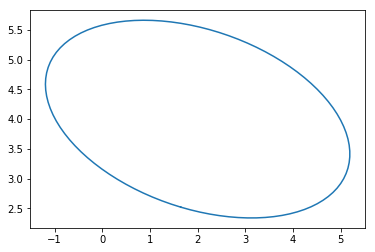

In [48]:
show2d(np.array([2,4]), Cov, sdwidth=2)

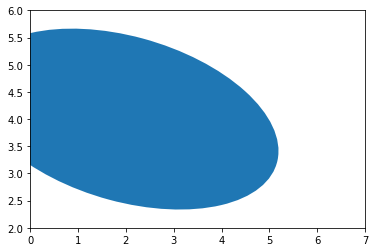

In [47]:
plot_cov_ellipse(Cov, [2,4])